In [1]:

#importing the neccessary libraries and loading the data into cv_img 
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

cv_img = []
for img in glob.glob("C:\\Users\\aniru\\Apple___healthy\\*.jpg"):
    n= cv2.imread(img)
    cv_img.append(n)
    
print(len(cv_img))

502


In [2]:
print(np.shape(cv_img))

(502, 256, 256, 3)


In [3]:
#defining all the functions
seed_value= 12321 

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z 
    
    return A, cache

def relu(Z):
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z<=0] = 0
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache 
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def initial_param(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1)) 
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters 

def initial_deepparam(layer_dims): 
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def prop_linear_forward(A, W, b): 
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache
def act_linear_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = prop_linear_forward(A_prev, W, b) 
        A, activation_cache = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_cache = prop_linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X 
    L = len(parameters) //2
    for l in range(1, L):
        A_prev = A 
        A, cache = act_linear_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation="relu")
        caches.append(cache)
        
    AL, cache = act_linear_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], activation="sigmoid")
    caches.append(cache)
    
    return AL, caches

def compute_cost(AL, Y): 
    
    m = Y.shape[1] 
    logprods = np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T)
    cost = -1/m*np.sum(logprods)
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

def prop_linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m*np.dot(dZ, A_prev.T)
    db = 1/m*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def act_linear_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = prop_linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = prop_linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches): 
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = act_linear_backward(dAL, current_cache, "sigmoid")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = act_linear_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["db" + str(l + 1)]
    return parameters


In [4]:
import time
import scipy
from PIL import Image
from scipy import ndimage 

In [5]:
Y = [] 
for item in cv_img:
    Y.append(1)


print(len(Y))

502


In [6]:

for img in glob.glob("C:\\Users\\aniru\\Apple___Unhealthy\\*.jpg"):
    n= cv2.imread(img)
    cv_img.append(n)
    Y.append(0) 

print(len(Y), " , ", len(cv_img))
Y_train = np.array([[item for item in Y ]])
print(Y_train.shape)


2262  ,  2262
(1, 2262)


In [7]:
valid_img = []
Yvalid = [] 
for img in glob.glob("C:\\Users\\aniru\\Validation\\Apple___healthy\\*.jpg"):
    n = cv2.imread(img)
    valid_img.append(n)
    Yvalid.append(1)
    
for img in glob.glob("C:\\Users\\aniru\\Validation\\Apple___Unhealthy\\*.jpg"):
    n = cv2.imread(img)
    valid_img.append(n)
    Yvalid.append(0)
    
print(len(valid_img), ",", len(Yvalid))
Y_valid = np.array([[item for item in Yvalid ]])

942 , 942


In [8]:
cv_img = np.array(cv_img)
valid_img = np.array(valid_img)

m_train = len(cv_img)
num_px = cv_img[1].shape[0]
m_valid = len(valid_img)

print ("Number of training examples: " + str(m_train))
print ("Number of validation examples: " + str(m_valid))

Number of training examples: 2262
Number of validation examples: 942


In [9]:
#reshaping the training and validation examples

train_x_flatten = cv_img.reshape(cv_img.shape[0], -1).T
valid_x_flatten = valid_img.reshape(valid_img.shape[0], -1).T

train_x = train_x_flatten/255
valid_x = valid_x_flatten/255
print("train_x shape: " + str(train_x.shape))
print("valid_x shape" + str(valid_x.shape))

train_x shape: (196608, 2262)
valid_x shape(196608, 942)


In [10]:
#implementing a 3-layer neural network now

layer_dims = [196608, 20, 7, 1]
def L_layer_model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = [] 
    parameters = initial_deepparam(layer_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL,Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print("cost after iteration %i: %F" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

cost after iteration 0: 0.692700
cost after iteration 100: 0.505359
cost after iteration 200: 0.380207
cost after iteration 300: 0.265858
cost after iteration 400: 0.228166
cost after iteration 500: 0.205024
cost after iteration 600: 0.269754
cost after iteration 700: 0.095801
cost after iteration 800: 0.070772
cost after iteration 900: 0.065224
cost after iteration 1000: 0.053009
cost after iteration 1100: 0.043466
cost after iteration 1200: 0.036742
cost after iteration 1300: 0.031483
cost after iteration 1400: 0.031045
cost after iteration 1500: 0.033555
cost after iteration 1600: 0.026936
cost after iteration 1700: 0.023034
cost after iteration 1800: 0.020039
cost after iteration 1900: 0.017586
cost after iteration 2000: 0.015528
cost after iteration 2100: 0.013783
cost after iteration 2200: 0.012290
cost after iteration 2300: 0.011003
cost after iteration 2400: 0.009885
cost after iteration 2500: 0.008909
cost after iteration 2600: 0.008053
cost after iteration 2700: 0.007299
cost

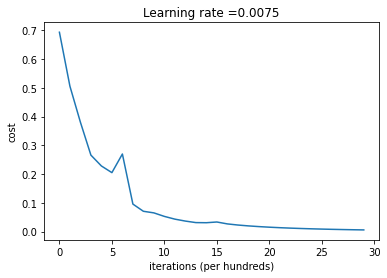

In [11]:
parameters = L_layer_model(train_x, Y_train, layer_dims, num_iterations = 3000, print_cost=True)

In [12]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) //2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [13]:
prediction_train = predict(train_x, Y_train, parameters)

Accuracy: 0.999557913351017


In [14]:
predictions_valid = predict(valid_x, Y_valid, parameters)

Accuracy: 0.994692144373673


In [15]:
newimage = cv2.imread('AppleCedarRust4.jpg')
Myimage = [] 
Myimage.append(newimage)
my_label_y = [0] 

Myimage = np.array(Myimage)
my_image = Myimage.reshape(Myimage.shape[0], -1).T

my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + str(int(np.squeeze(my_predicted_image))) +  "\" picture.")

Accuracy: 1.0
y = 0.0, your L-layer model predicts a "0" picture.
